In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# import library
berikut library yang saya gunakan

In [ ]:
df = pd.read_csv("Dataset_B_hotel.csv")

missing_values = df.isnull().sum()
unique_values = df.nunique()

summary_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Unique Values': unique_values,
    'Data Type': df.dtypes
})

cat_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']


unique_values = {col: df[col].dropna().unique().tolist() for col in cat_cols}

unique_values, summary_df


({'type_of_meal_plan': ['Meal Plan 1',
   'Not Selected',
   'Meal Plan 2',
   'Meal Plan 3'],
  'room_type_reserved': ['Room_Type 1',
   'Room_Type 4',
   'Room_Type 2',
   'Room_Type 6',
   'Room_Type 5',
   'Room_Type 7',
   'Room_Type 3'],
  'market_segment_type': ['Offline',
   'Online',
   'Corporate',
   'Aviation',
   'Complementary'],
  'booking_status': ['Not_Canceled', 'Canceled']},
                                       Missing Values  Unique Values Data Type
 Booking_ID                                         0          36275    object
 no_of_adults                                       0              5     int64
 no_of_children                                     0              6     int64
 no_of_weekend_nights                               0              8     int64
 no_of_week_nights                                  0             18     int64
 type_of_meal_plan                                907              4    object
 required_car_parking_space                      1

# check data
- melihat data, disini saya melakukan listing kepada categorical, sehingga bisa dilihat didalam categorical ada list data apa saja ayng bisa di masukkan
- saya juga melihat missing value, agar bisa di proses nanti

In [ ]:


df.drop(['Booking_ID', 'arrival_year', "arrival_date"], axis=1, inplace=True)

df['type_of_meal_plan'].fillna(df['type_of_meal_plan'].mode()[0], inplace=True)
df['required_car_parking_space'].fillna(df['required_car_parking_space'].mode()[0], inplace=True)
df['avg_price_per_room'].fillna(df['avg_price_per_room'].mean(), inplace=True)

df['high_cancel_flag'] = df['no_of_previous_cancellations'].apply(lambda x: 1 if x >= 3 else 0)


cat_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']
label = LabelEncoder()
for col in cat_cols:
    df[col] = label.fit_transform(df[col])

X = df.drop('booking_status', axis=1)
y = df['booking_status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pre process
- melakukan drop kepada data yagng tidak berguna
- mengisi data data kosong modus untuk categorical dan mean untuk harga rata rata
- untuk required car park saya mengisi dengan data terbanyak
- melakukan encoding untuk data categorical
- target fitur yaitu booking status di drop dan dijadikan y col
- melakukan standard scaling agar value ter standarisasi, agar value yang besar misalnya harga tidak overwhelming
- mencoba menggunakan SMOTE (untuk meningkatkan F1 tapi sama aja sih), tujuannya agar kasus kasus yang jarang ditemukan bisa dipelajari
- mmabagi data menjadi data train dan test

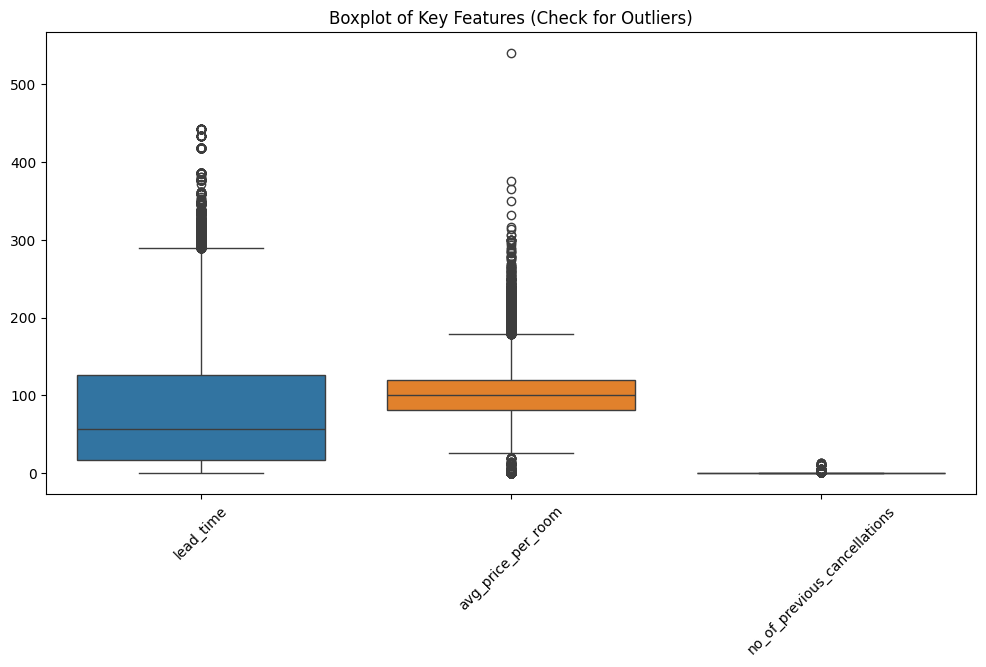

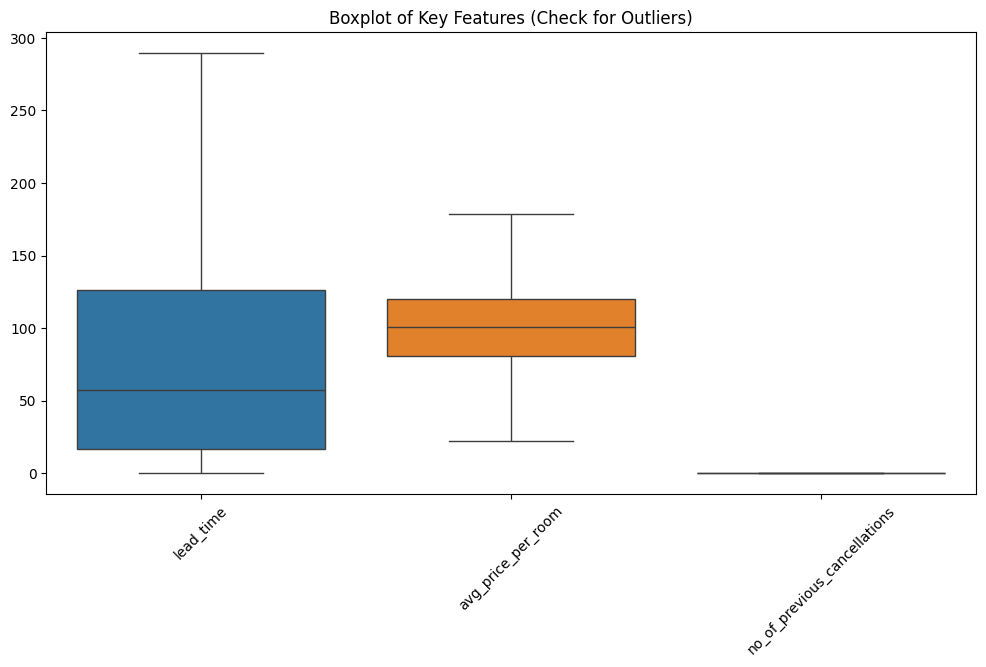

In [104]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['lead_time', 'avg_price_per_room', 'no_of_previous_cancellations']])
plt.title("Boxplot of Key Features (Check for Outliers)")
plt.xticks(rotation=45)
plt.show()


def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

for col in ['lead_time', 'avg_price_per_room', 'no_of_previous_cancellations']:
    df[col] = cap_outliers(df[col])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['lead_time', 'avg_price_per_room', 'no_of_previous_cancellations']])
plt.title("Boxplot of Key Features (Check for Outliers)")
plt.xticks(rotation=45)
plt.show()


# cek outliers
- melihat outliers pada 3 data utama yaitu lead_time, avg_price, prev_cancelation
- membenarkan outlier menggunakan inter quartile range

setalah outlier dibenarkan f1 score dari model bertambah sebanyak 0.01, atau 1%

In [105]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced'],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [106]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='f1')

# searching best model
- mencari menggunakan random forest dan xgboost, serta melakukan hyper parameter tuning, dengan mencoba smeua kombinasi,d an mencari yang terbaik

grid dari parameter saya coba coba, dna isi dari internet, karena memang ada beberapa tebakan yang lebih baik dari tebakan-tebakan 
asal, jadi saya mencoba tebakan tersebut daripada mencoba memasukkan semua grid

In [109]:
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_


rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)


y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)


rf_report = classification_report(y_test, rf_pred, output_dict=True)
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)


print(f"train f1: {f1_score(y_train, y_train_pred):.4f}")
print(f"test f1: {f1_score(y_test, y_test_pred):.4f}")


def print_rep(model_name, report):
    print(f"{model_name} result")
    print(f"{'Class':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'Support'}")
    for label in ['0', '1']:
        metrics = report[label]
        print(f"{label:<12}{metrics['precision']:<12.2f}{metrics['recall']:<12.2f}{metrics['f1-score']:<12.2f}{int(metrics['support'])}")
    print(f"{'Accuracy':<12}{report['accuracy']:.2f}")


print_rep("rf", rf_report)
print_rep("xgb", xgb_report)


train f1: 0.9764
test f1: 0.9237
rf result
Class       Precision   Recall      F1-Score    Support
0           0.86        0.83        0.84        2416
1           0.91        0.93        0.92        4839
Accuracy    0.90
xgb result
Class       Precision   Recall      F1-Score    Support
0           0.87        0.80        0.83        2416
1           0.90        0.94        0.92        4839
Accuracy    0.89


# hasil
hasil menunjukkan tidak terlalu berbeda, denagn random forest lebih unggul 1% dalam total akurasi, disini saya menggunakan metrik pengukuran f1 karena menggabungkan precision dan recall.

karena hasil relatif lebih baik random forest, maka kita akan menggunakan rnadom forest untuk model kita

saya juga melakukan pengecekan f1 score untuk random forest pada train dan test, terdapat perbedaan sekitar 5%
hal ini saya lakukan untuk melihat aapakah model saya overfitting, dan angka 5% menurut saya relatif rendah, dan model dari random forest tidak overfitting
